# Practical 3 - Dimensionality Reduction and Clustering

This practical uses the data set from https://www.nature.com/articles/s41586-018-0654-5. This is single cell transcriptomics data from ~25,000 cells from the cortex. For each of these cells, the expression of several thousand genes was measured. In the original study, the authors were interested in clustering the cells into types. 

We made a selection of 5000 cells and the 1000 most informative genes for run time reasons. We provide you with the original cell type labels determined by the authors for comparison.


In [1]:
# Prepare
import itertools
import numpy as np
from numpy import linalg as LA
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(context='talk',style='white',palette='colorblind')
import pickle
import scipy
import matplotlib
from scipy import sparse
import sklearn
import sklearn.mixture
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
import scipy as sp
import urllib.request 
import pandas as pd
from scipy.stats import multivariate_normal
from matplotlib import style
style.use('fivethirtyeight')

## Task 0: Load and normalize count data

In [2]:
def lognormalize_counts(tasic_dict):
    
    #normalize and logtransform counts
    counts = tasic_dict['counts']
    libsizes = counts.sum(axis=1)
    CPM = counts / libsizes * 1e+6
    logCPM = np.log2(CPM + 1) 
    tasic_dict['logCPM'] = logCPM  
    
    return tasic_dict

In [3]:
tasic_1k = lognormalize_counts(pickle.load(open('tasic_subset_1kselected.pickle', 'rb')))

In [4]:
print(tasic_1k['logCPM'].shape)

(5000, 1000)


## Task 1: Linear dimensionality reduction with PCA [15 points]

In this task, you will use principle component analysis (PCA) to reduce the dimensionality of the dataset.

First, implement PCA "by hand". You can use `numpy.linalg.eig()`  but no `sklearn`-functions. Write a function that computes all possible principle components, and returns them along with the fraction of variance they explain.

In [5]:
C = (1/1000)*tasic_1k['logCPM'].T@tasic_1k['logCPM']
cov = np.cov(tasic_1k['logCPM'], rowvar=0)
w, v = LA.eig(cov)
fraction_variance_explained = w/sum(w)

In [6]:
def PCA_manual(data):
    '''
    Function that performs PCA on the input data
    
    input: (cells,genes)-shaped array of log transformed cell counts
    output:
        fraction_variance_explained: (genes,)-shaped array with the fraction of variance explained by the individual PCs
        principal_components: (genes,genes)-shaped array containing the principal components as columns
    '''
    ### NOTE: Make sure the function returns the PCs sorted by the fraction of variance explained! ###
    ###       (First column of principal_components should hold the PC with the highest variance   ###
    ###       explained -- fraction_variance_explained should also be sorted accordingly)          ###

    # INSERT YOUR CODE HERE
    cov = np.cov(data, rowvar=0)
    w, principal_components = LA.eig(cov)
    fraction_variance_explained = w/sum(w)
    
    #sort the eigen value and eigen vecotors
    eigen_id = np.argsort(w)[::-1]
    w = w[eigen_id]
    principal_components = principal_components[:,eigen_id]
    fraction_variance_explained = w/sum(w)
    
    return fraction_variance_explained,principal_components

In [7]:
var_expl, PCs = PCA_manual(tasic_1k['logCPM'])

Before we explore the structure of the low dimensional representation, we first want to know how much variance the first PCs explain: 

- Plot the variance explained of the `n`-th PC vs. `n`

- Plot the cumulative variance explained for the `n` PCs with highest variance explained vs. `n`

From the latter plot you should be able to see how much PCs you need to keep to explain at least `x`% of the variance.

How many components to you need to keep to explain 50%, 75%, 90% and 99%, respectively? Indicate this in your plot.

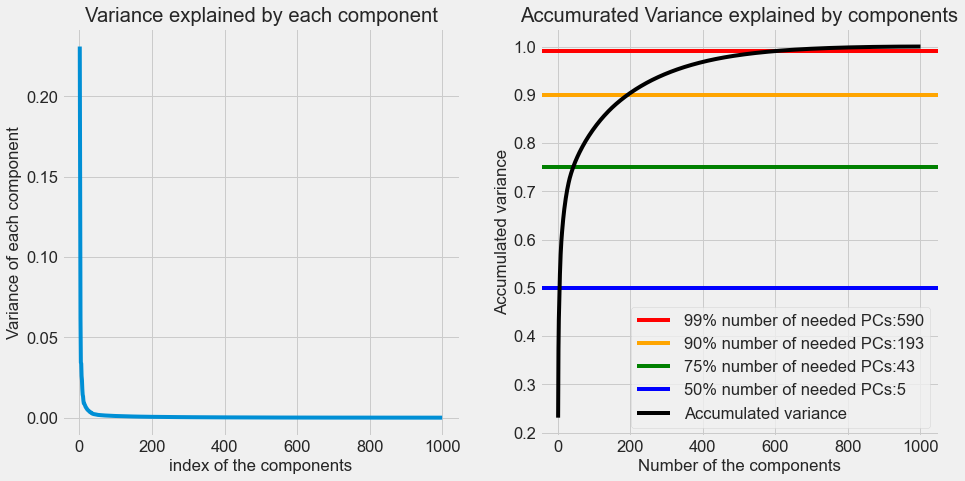

In [34]:
fig = plt.figure(figsize=(14,7))

# INSERT YOUR CODE HERE

ax = fig.add_subplot(1, 2, 1)
#plt.subplot(121)

# INSERT YOUR CODE HERE
len(var_expl)
lst = list(range(1,len(var_expl)+1))
plt.plot(lst, var_expl)
plt.xlabel("index of the components")
plt.ylabel("Variance of each component")
ax.set_title("Variance explained by each component")

ax = fig.add_subplot(1, 2, 2)
#plt.subplot(122)

# INSERT YOUR CODE HERE
cum_var = var_expl.cumsum()

_50,PCs50 = select_PCs(var_expl,PCs,percent_variance=0.50)
_75,PCs750 = select_PCs(var_expl,PCs,percent_variance=0.75)
_90,PCs90 = select_PCs(var_expl,PCs,percent_variance=0.90)
_99,PCs99 = select_PCs(var_expl,PCs,percent_variance=0.99)

plt.axhline(y=0.99, color='red', label="99% number of needed PCs:" + str(len(_99)))
plt.axhline(y=0.9, color='orange', label="90% number of needed PCs:" + str(len(_90)))
plt.axhline(y=0.75, color='green', label="75% number of needed PCs:" + str(len(_75)))
plt.axhline(y=0.5, color='blue', label="50% number of needed PCs:" + str(len(_50)))
    
ax.plot(lst, cum_var, color='black', label='Accumulated variance')

plt.xlabel("Number of the components")
plt.ylabel("Accumulated variance")
ax.set_title("Accumurated Variance explained by components")

plt.legend()
plt.show()


YOUR ANSWER HERE: In order to explain 50% of the variance, they need 5 PCs. In order to explain 75% of the variance, they need 43 PCs. In order to explain 90% of the variance, they need 193 PCs. In order to explain 99% of the variance, they need 590 PCs.

Write a function to select the `n` PCs needed to explain at least `x`% of the variance and use this function to extract as many PCs as are needed to explain 75% of the variance. 

In [11]:
def select_PCs(variance_explained,principal_components,percent_variance=None):
    '''Function that selects the first n principal components necessary to explain x% of the variance
    input: 
        variance_explained: amount of variance explained by the individual PCs
        principal_components: contains the principal components as columns
        percent_variance: fraction of the variance, the all PCs that are kept explain
    output:
        variance_explained_kept: individual amount of variance explained for the remaining PCs
        principal_components_kept: remaining principal components, shape (genes,n_PCs_kept)
                
    '''
  
    # INSERT YOUR CODE HERE
    cum_var_exp = variance_explained.cumsum()
    num_pre = len(list(filter(lambda x: x < percent_variance, cum_var_exp)))
    variance_explained_kept = variance_explained[:num_pre+1]
    principal_components_kept = principal_components[:,:num_pre+1]
         
    return variance_explained_kept,principal_components_kept

In [12]:
_,PCs75 = select_PCs(var_expl,PCs,percent_variance=0.75)

To compute the representation of the data in this lower dimensional representation, write a function that compute the PC scores for each cell, i.e. that projects the original data matrix on the low-dimensional subspace provided by the first `n` PCs:

In [13]:
def compute_PCA_scores(data,principal_components):
    '''Function that returns the PC scores for each data point
    input: 
        data                 --- (cells,genes)-shaped array of log transformed cell counts
        principal_components --- contains the principal components as columns\
    output:
        pc_scores            --- (cells,n_PCs_kept)-shaped array of PC scores
    
    ''' 
    
    # INSERT YOUR CODE HERE
    pc_scores = data @ principal_components
   
    return pc_scores

In [14]:
tasic_1k['PCA_75'] = compute_PCA_scores(tasic_1k['logCPM'],PCs75)

Finally, visualize the top 5 PCs as a pairwise scatterplot. Use a 5x2 subplot grid of scatter plots, and use one subplot for each pair of components.

Also, use the colors provided in `data['clusterColors']` and the cluster information in `data['clusters']` to color each data point according to its original cluster identity. The colors indicate the family of the cell type:

- greenish colors: excitatory neurons
- orange colors: somatostatin positive interneurons
- pinkish colors: VIP-postive interneurons
- reddish colors: parvalbumin positive interneurons
- dark colors: non-neurons (glia etc)

What do you observe?

In [15]:
test = tasic_1k['PCA_75'][:,0].tolist()
len(test)

5000

In [37]:
def plot_PCs(data_transformed,color_per_datapoint):
    '''Function that plots the scores of the 10 pairs of the top 5 PCs against each other.
        inputs:
            data_transformed    -- (cells,n_PCs_kept)-shaped array of PC scores
            color_per_datapoint -- (cells,)-shaped array of color strings, one color for each cell
    '''
   
    
    # INSERT YOUR CODE HERE    
    l = [0, 1, 2, 3, 4]
    c = itertools.combinations(l, 2)
    c_list = list(itertools.combinations(l, 2))
    #print(c_list)
    fig,axes = plt.subplots(5,2,figsize=(15,35))
    axes=axes.flatten()
    for i,ax in enumerate(axes):
        ax.scatter(data_transformed[:,c_list[i][0]].tolist(), data_transformed[:,c_list[i][1]].tolist(), color=color_per_datapoint)
        label="99% number of needed PCs:" + str(len(_99))
        ax.set_xlabel(str(c_list[i][0] + 1) + "th PC")
        ax.set_ylabel(str(c_list[i][1] + 1) + "th PC")
        ax.set_title("PCs scatter plot with " + str(c_list[i][0] + 1) + "th and " + str(c_list[i][1] + 1) + "th")
        
    plt.show()
    

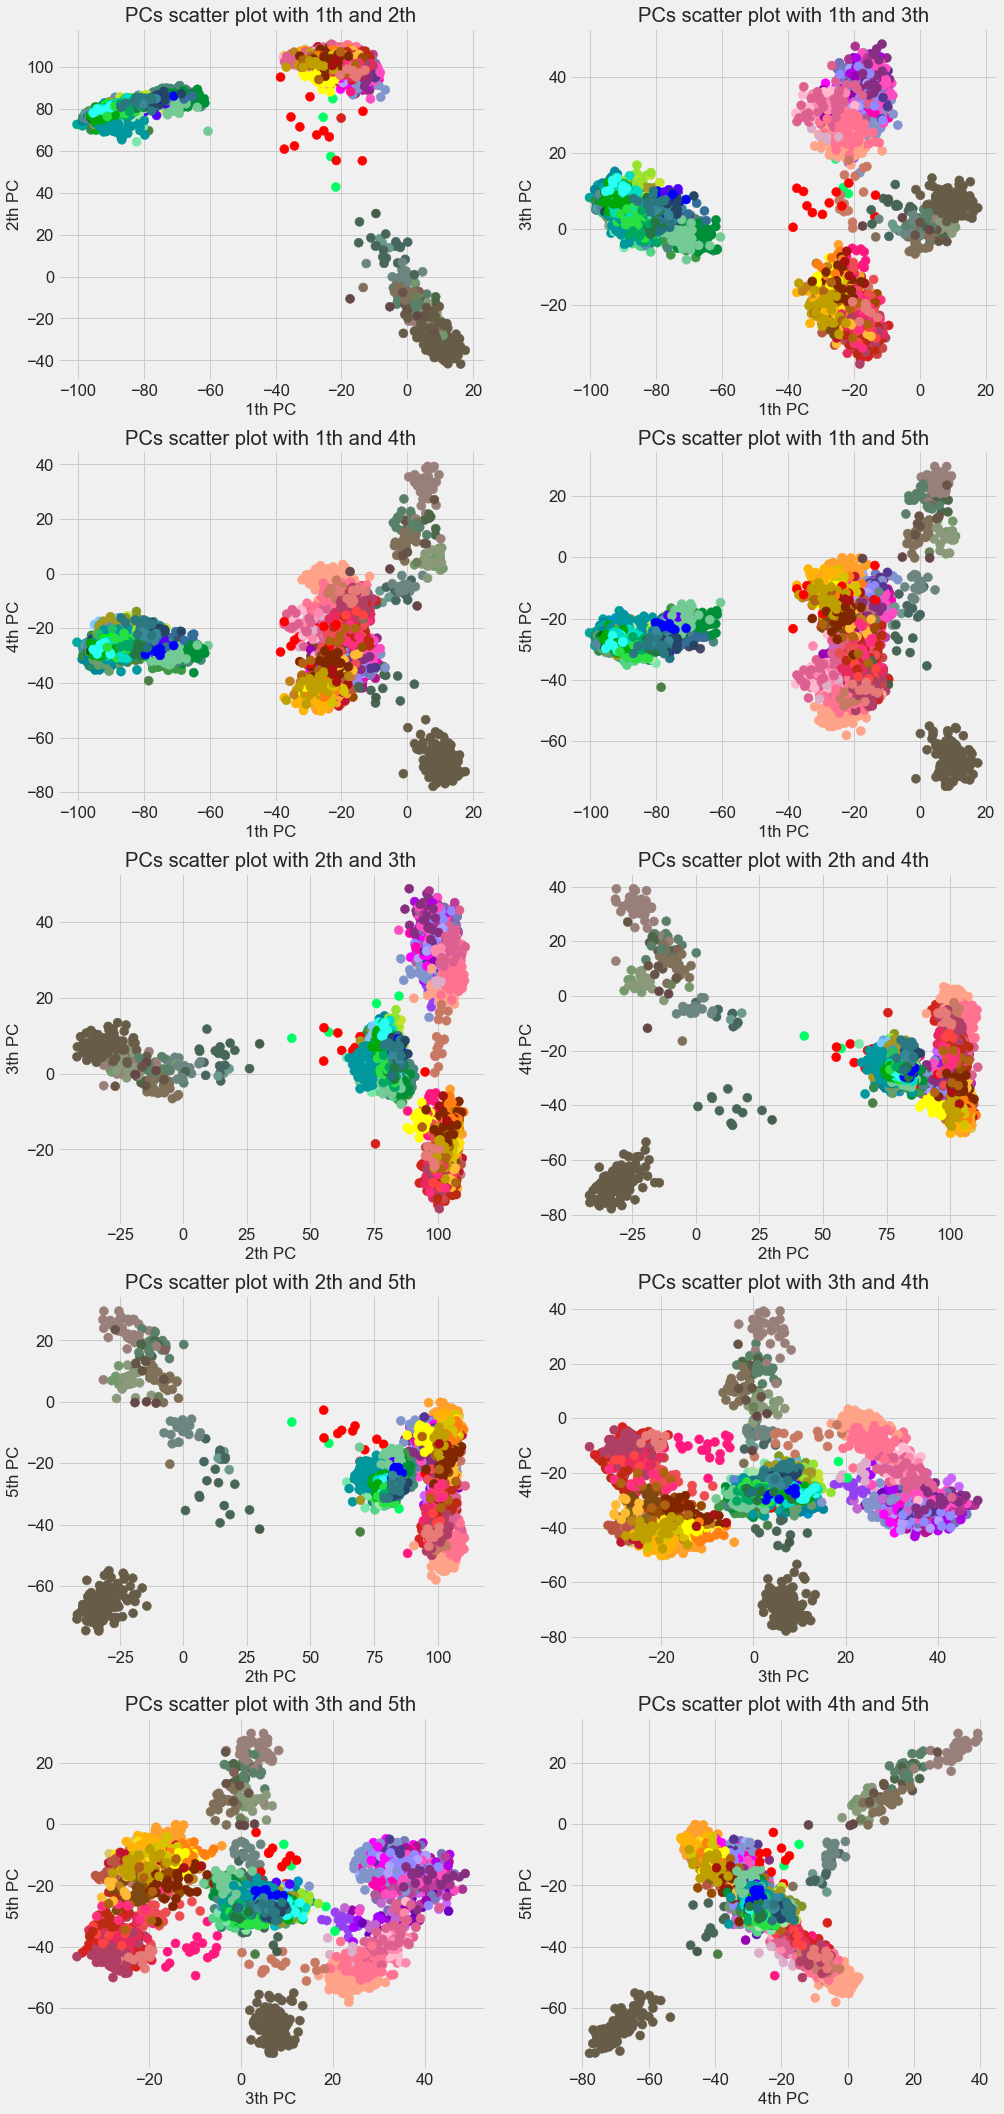

In [38]:
color_per_datapoint = tasic_1k['clusterColors'][tasic_1k['clusters']]
plot_PCs(tasic_1k['PCA_75'],color_per_datapoint)

YOUR ANSWER HERE: (1st-2nd)We clearly see that they are separated into three parts: green, orange-red-pink, dark. (1st-3rd)We clearly see that they are separated into four parts: green, orange-pink, red, dark. These two graphs look well at separating the data. 

(1st-4th)(1st-5th)We see that they are separated into four parts: green, orange-pink-red, two dark.(2nd-3rd)We see that they are separated into four parts: green, pink, orange-red, dark.(2nd-4th)(2nd-5th)We see that they are separated into four parts: green, pink, orange-ref, dark.(3rd-4th)(3rd-5th)(4rd-5th)It seems that we should extract other dimensions.

## Task 2: Comparison with PCA implemented by sklearn [5 pts]

We provide the results of the sklearn PCA to make sure you have the same PCA-transformed data as everyone else in the class in the remaining tasks and obtain some insights into numerical precision of the algorithms underlying PCA implementations.

In [18]:
def PCA_sklearn(data):
    '''
    Function that performs PCA on the input data, using sklearn
    
    input: (cells,genes)-shaped array of log transformed cell counts
    output:
        fraction_variance_explained: (genes,)-shaped array with the fraction of variance explained by the individual PCs
        principal_components: (genes,genes)-shaped array containing the principal components as columns
    '''

    # INSERT YOUR CODE HERE   
    pca = PCA()
    pca.fit(data)
    fraction_variance_explained = pca.explained_variance_ratio_
    principal_components = pca.components_.T
     
    return fraction_variance_explained, principal_components

In [19]:
#do sklearn-PCA on selected genes
var_expl_sklearn,PCs_sklearn = PCA_sklearn(tasic_1k['logCPM'])
#select components as before
_,PCs_sklearn75 = select_PCs(var_expl_sklearn,PCs_sklearn,0.75)
#get PC scores
PCA_75_sklearn = compute_PCA_scores(tasic_1k['logCPM'],PCs_sklearn75)

To see if your manual PCA yielded the same PC weights as the sklearn PCA, we can just take the two matrices of principle components and plot their entries against each other. (Note: This again assumes they are sorted by variance explained..)

Use the following plot to compare the results to your own implementation (here plotting the weights of the first 100 PCs against each other). What do you think where the noise comes from?

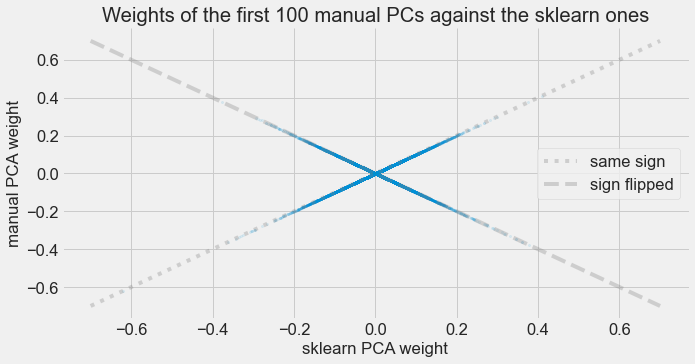

In [20]:
n_evs_to_compare=100
    
plt.figure(figsize=(10,5))
plt.scatter(PCs_sklearn[:,:n_evs_to_compare].flatten(),PCs[:,:n_evs_to_compare].flatten(),s=5,alpha=0.1)
plt.plot([-.7,.7],[-.7,.7],':',c='tab:gray',label='same sign',alpha=0.3)
plt.plot([-.7,.7],[.7,-.7],'--',c='tab:gray',label='sign flipped',alpha=0.3)
plt.legend()
plt.xlabel('sklearn PCA weight')
plt.ylabel('manual PCA weight')
plt.title('Weights of the first %u manual PCs against the sklearn ones' % (n_evs_to_compare))

sns.despine()

In [21]:
print(PCs[:, :100])
#the sign was different

[[ 0.00286842 -0.00739914 -0.00041094 ...  0.00197488  0.00072559
   0.00644431]
 [ 0.00089091 -0.00277467 -0.00025961 ...  0.00170574 -0.00289652
   0.0016366 ]
 [ 0.00201184 -0.00623016 -0.00030709 ...  0.00042273  0.00339761
   0.0010343 ]
 ...
 [ 0.0032056  -0.00933703 -0.00024797 ... -0.0008885   0.00279187
  -0.00431813]
 [ 0.00318976 -0.00935594 -0.00073552 ... -0.00447347 -0.00847929
  -0.00064774]
 [-0.0192646   0.06945445 -0.00782304 ... -0.01273956  0.01773225
  -0.00574903]]


YOUR ANSWER HERE: When I output the above plot of the data without sorting the PCs based on the explained variance, I got the noise on the above plot. And, PCs which are not sorted by the explained variance had the different sign of the PCs, so it seems signs of the PCs gives noises.

Additional reading about the sign of PCs: https://stats.stackexchange.com/questions/88880/does-the-sign-of-scores-or-of-loadings-in-pca-or-fa-have-a-meaning-may-i-revers

## Task 3: Nonlinear dimensionality reduction with t-SNE [5 pts]

In this task, you will use the nonlinear dimensionality reduction technique tSNE and look at visualizations of the data set. First, run the default t-SNE and store the result in a variable you keep, as you will use it for plotting in the next tasks as well. Plot the result of default t-SNE with the original cluster colors. For this and the following tasks, use the PCs explaining 75% of the variance you stored in ```tasic_1k['PCA_75']``` above.

In [22]:
def plot_tsne(tsne_results, clusters=tasic_1k['clusters'], labels=['']):
    '''Plotting function for tsne results, creates one or multiple plots of tSNE-transformed data.
       If the clustering is the original one (default), original cluster colors will be used. Otherwise,
       colors will be a random permutation.
    
    input:
        tsne_results: (n,2)-shaped array containing tSNE-transformed data or list of such arrays
                      (output of the fit_transform function of sklearn tSNE)
        clusters: (n,)-shaped array containing cluster labels or list of such arrays
        labels: optional, list of titles for the subplots
    '''
    
    if type(tsne_results)==list: # make sure we can do both single and multiple plots and are flexible regarding input
        num_plots = len(tsne_results)
    else:
        num_plots = 1
        tsne_results = [tsne_results]
    if type(clusters)==list:
        num_clusters = len(clusters)
        num_plots = num_plots * num_clusters
        tsne_results = tsne_results * num_clusters
    else:
        clusters = [clusters]*num_plots
    
    if len(labels)==1:
        labels = labels*num_plots
        
    n_clusters = len(np.unique(clusters))      # ensure a long enough color list even if we plot more than 
    n_colors = len(tasic_1k['clusterColors'])  # the original number of clusters
    if n_clusters > n_colors:
        n_extra_colors = n_clusters - n_colors
        colors = np.concatenate((tasic_1k['clusterColors'],tasic_1k['clusterColors'][:n_extra_colors]))    
    else:
        colors = tasic_1k['clusterColors']

    fig, ax = plt.subplots(num_plots,1,figsize=(10,num_plots*10))
    if num_plots==1:
        if not np.all(tasic_1k['clusters']==clusters[0]):
            current_colors = np.random.permutation(colors)
        else:
            current_colors = colors
        ax.scatter(tsne_results[0][:,0], tsne_results[0][:,1], s=1, color=current_colors[clusters[0]])
        ax.set_title(labels[0])
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_axis_off()
    else:
        for i in range(num_plots):
            if not np.all(tasic_1k['clusters']==clusters[i]):
                current_colors = np.random.permutation(colors)
            else:
                current_colors = colors
            ax[i].scatter(tsne_results[i][:,0], tsne_results[i][:,1], s=1, color=current_colors[clusters[i]])
            ax[i].set_title(labels[i])
            ax[i].set_xticks([])
            ax[i].set_yticks([])
            ax[i].set_axis_off()
            
            

In [23]:
original_clusters = tasic_1k['clusters']
print(original_clusters.shape)

# INSERT YOUR CODE HERE
tsne_results = TSNE(n_components=2).fit_transform(tasic_1k['PCA_75'])

(5000,)


In [24]:
tsne_results.shape

(5000, 2)

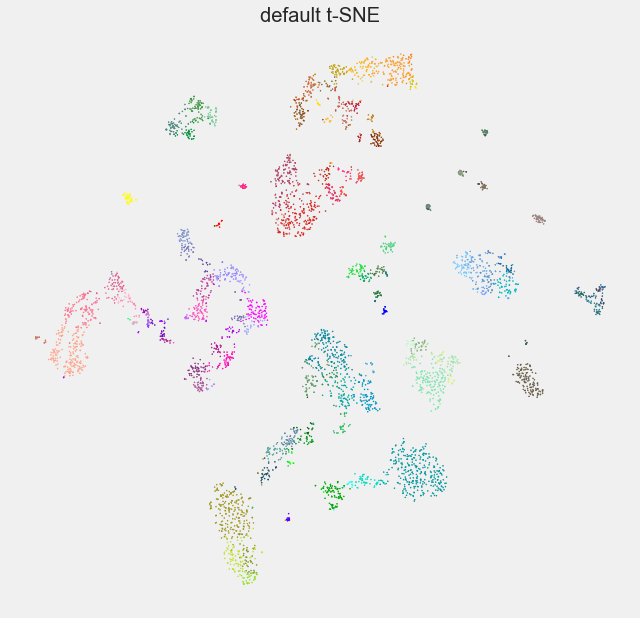

In [25]:
plot_tsne(tsne_results,original_clusters,labels=['default t-SNE'])

t-SNE has one main parameter called perplexity, which trades of local and global structure. Its default value is 30. Run the tSNE with some other perplexity values (e.g. 5, 100), plot the results next to each other and explain what you observe. In particular, compare with the PCA plot above.

In [26]:
# Try different perplexities

# INSERT YOUR CODE HERE
tsne_perplexity = []
tsne_perplexity.append(TSNE(n_components=2, perplexity = 30).fit_transform(tasic_1k['PCA_75']))
tsne_perplexity.append(TSNE(n_components=2, perplexity = 5).fit_transform(tasic_1k['PCA_75']))
tsne_perplexity.append(TSNE(n_components=2, perplexity = 100).fit_transform(tasic_1k['PCA_75']))

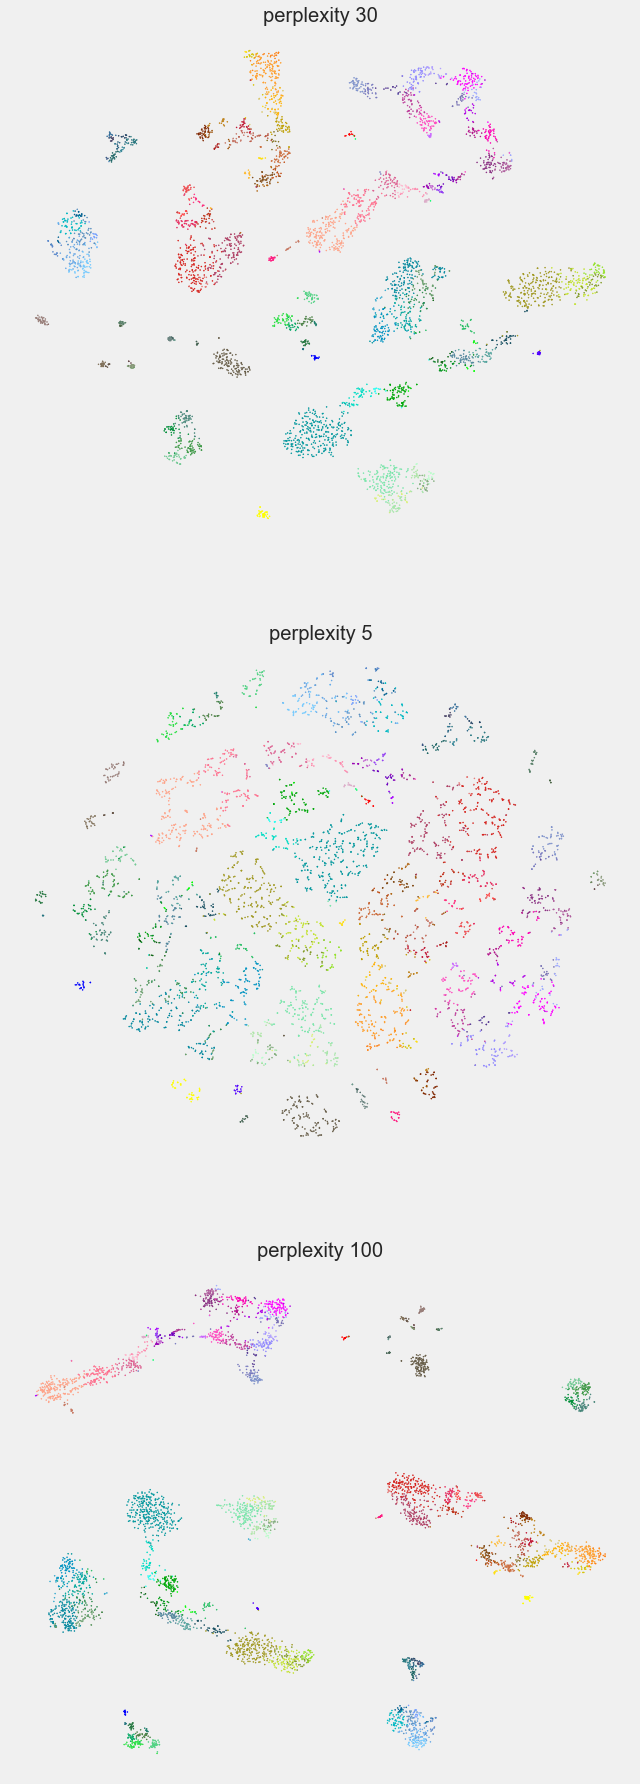

In [27]:
# Plot results

plot_tsne(tsne_perplexity,original_clusters,labels=['perplexity 30', 'perplexity 5', 'perplexity 100'])

YOUR ANSWER HERE: When I compare the plot with perplexity 30 and the default plot, they are similar to each other. When I compare the three plot with perplexity 5, 30 and 100, the larger the perplexity becomes, the more clear the boundary between clusters becomes and the more concentrated dots into one cluster.

## Task 4: Cluster the data using k-Means [5 pts]

So far, we only visualized the data and plotted it with the original cluster labels. As a next step, we will implement k-Means as an example of a simple clustering algorithm and see how it performs on the dataset. Use the function KMeans provided by sklearn to perform K-Means with different numbers of clusters. Plot your results as cluster labels in the tSNE map and compare it to the original cluster labels. Describe your results.

In [28]:
def run_KMeans(n_clusters):
    '''Function that performs K-means clustering for a given number of clusters
        input: number of clusters
        output: Cluster labels (K-means prediction)
    '''
    
    # INSERT YOUR CODE HERE
    kmeans_result=KMeans(n_clusters).fit_predict(tasic_1k['PCA_75'])
    
    return kmeans_result

In [29]:
# Run kmeans with different numbers of clusters (5, 10, 20, 50)

# INSERT YOUR CODE HERE
kmeans_result = []
kmeans_result.append(run_KMeans(5))
kmeans_result.append(run_KMeans(10))
kmeans_result.append(run_KMeans(20))
kmeans_result.append(run_KMeans(50))


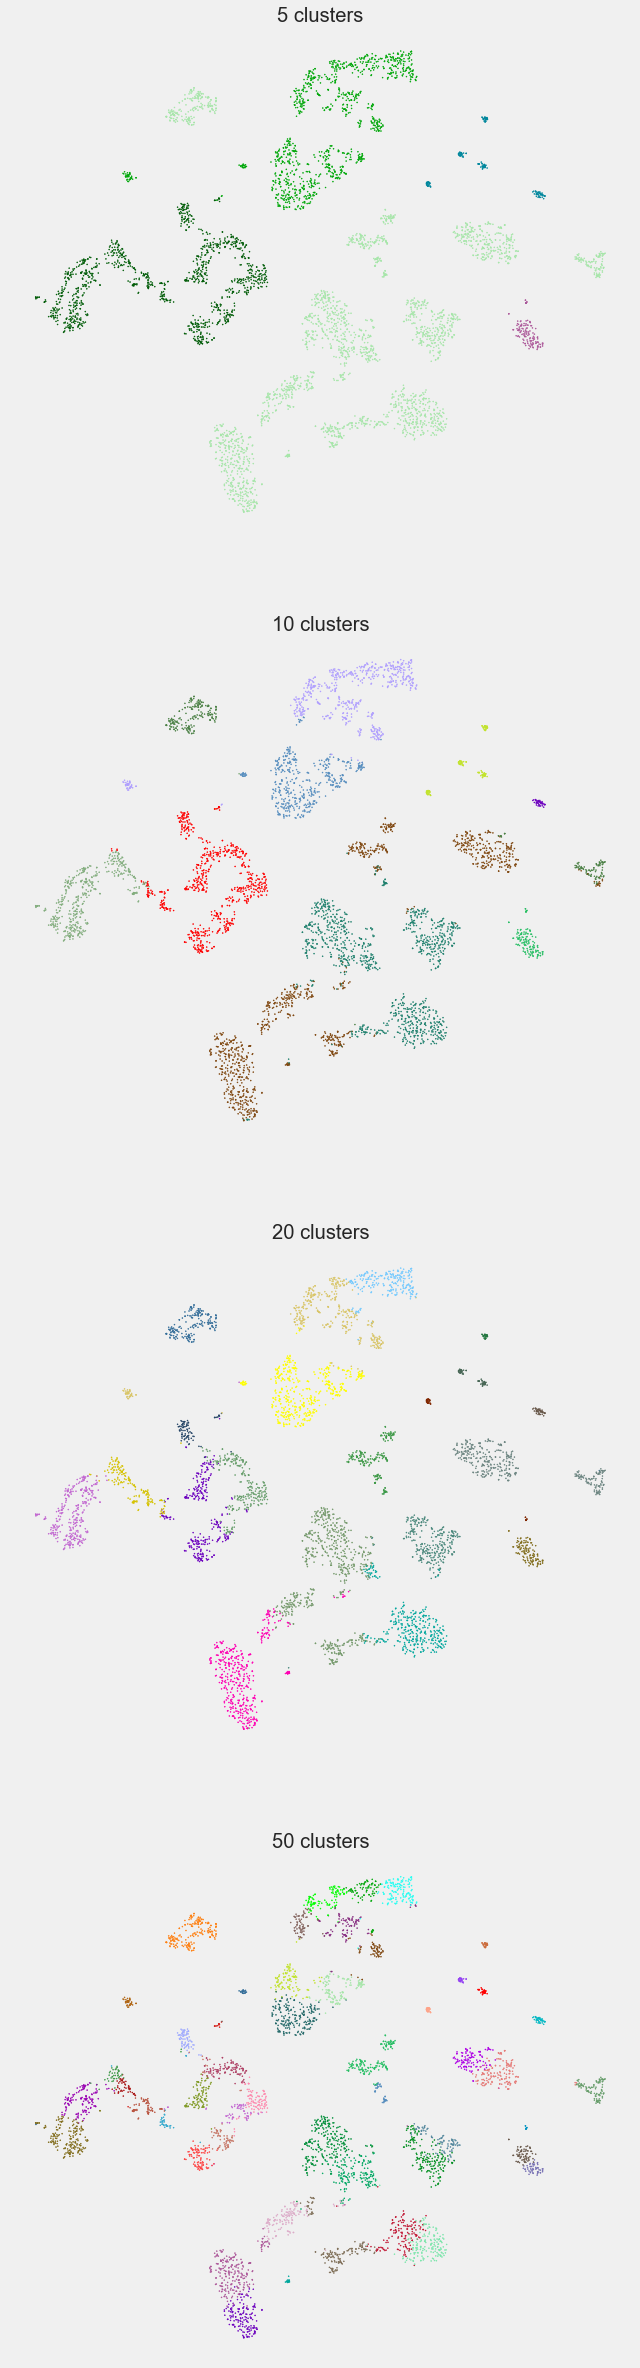

In [31]:
# Plot results

# INSERT YOUR CODE HERE 
plot_tsne(tsne_results,kmeans_result,labels=['5 clusters','10 clusters','20 clusters','50 clusters' ])

YOUR ANSWER HERE: On the plot with 5 and 10 clusters, cluster based on the k-means doesn't divide the original graphical cluster. However, on the plot with 20 and 50 clusters, cluster based on the k-means divides the original graphical cluster. It seems 10 kmeans cluster is appropreate to divide the datasets.

##  Task 5: Clustering using Gaussian Mixture Models [20 points]

Finally, we will implement clustering with Gaussian Mixture models. To this end, we will first generate toy data to later verify the correct implementation of the algorithm and then implement the algorithm using EM and run it on the transcriptomics data set. 

Sample 1000 data points from a two dimensional mixture of Gaussian model with three clusters  and the following parameters:

$\mu_1 = \begin{bmatrix}0\\0\end{bmatrix}, \Sigma_1 = \begin{bmatrix}1 & 0\\0 & 1\end{bmatrix}, \pi_1=0.3$

$\mu_2 = \begin{bmatrix}5\\1\end{bmatrix}, \Sigma_2 = \begin{bmatrix}2 & 1\\1 & 2\end{bmatrix}, \pi_2=0.5$

$\mu_4 = \begin{bmatrix}0\\2\end{bmatrix}, \Sigma_3 = \begin{bmatrix}1 & -0.5\\-0.5 & 1\end{bmatrix}, \pi_3=0.2$

Plot the sampled data points and indicate in color the cluster each point came from. Plot the cluster means as well.

In [39]:
def sampleData(N, means, covariances, priors):
    '''Generate N samples from a Mixture of Gaussian distribution.
    
    inputs:
        N           -- number of samples
        means       -- (n_cluster,n_dimensions)-shaped array of mean vectors
        covariances -- (n_dimensions,n_dimensions,n_cluster)-shaped array of covariance matrices
        prioirs     -- (n_cluster)-shaped arrays of priors / mixing coefficients
    outputs:
        data        -- (N,n_dimensions)-shaped array of simulated data
        cluster_ids -- (N,)-shaped array of integers that hold the cluster assignment for each data point

    '''
    
    # INSERT YOUR CODE HERE 
    
    # genetating N pre-samples which is reflected the priors
    z_truth_nk = np.random.multinomial(n=1, pvals=priors, size=N)
    
    # extract the labels of samples
    _, cluster_ids = np.where(z_truth_nk == 1)
    
    # generate samples
    data = np.array([
        np.random.multivariate_normal(
            mean=means[k], cov=covariances[k], size=1
        ).flatten() for k in cluster_ids
    ])

    return data,cluster_ids 

In [40]:
# Set up sampling

# INSERT YOUR CODE HERE
# number of the dimension
D = 2

# number of the clusters
K = 3

N = 1000
toy_means = np.array(
    [[0, 0], 
     [5, 1], 
     [0, 2]]
)
toy_covs = np.array(
    [[[1, 0], [0, 1]], 
     [[2, 1], [1, 2]], 
     [[1, -0.5], [-0.5, 1]]]
)
toy_priors = np.array([0.3, 0.5, 0.2])

toy_data, toy_cluster_ids_true = sampleData(N, toy_means, toy_covs, toy_priors)

In [43]:
def plot_clustering(data,cluster_ids,means,title):
    '''
    Plots the (2D) data as scatter plot, with different colors and an extra symbol for the mean per cluster.
    inputs:
        data        -- (N,n_dimensions)-shaped array of data
        cluster_ids -- (N,)-shaped array of integers that hold the cluster assignment for each data point
        means       -- (n_cluster,n_dimensions)-shaped array of mean vectors
        title       -- string that is added as title

    '''
    
    # INSERT YOUR CODE HERE
    
    plt.figure(figsize=(6, 6))
    for k in range(K):
        k_idx, = np.where(cluster_ids == k) # indices of the toy data in cluster k
        plt.scatter(x=data[k_idx, 0], y=data[k_idx, 1], label='cluster:' + str(k + 1)) # toy data
    plt.suptitle(title, fontsize=20)
    #plt.scatter(0, 0, color = "black")
    #plt.scatter(5, 1, color = "black")
    #plt.scatter(0, 2, color = "black")
    plt.scatter(means[0][0],means[0][1] , color = "black")
    plt.scatter(means[1][0],means[1][1] , color = "black")
    plt.scatter(means[2][0],means[2][1] , color = "black")
    plt.xlabel('$x_1$')
    plt.ylabel('$x_2$')
    
    plt.show()


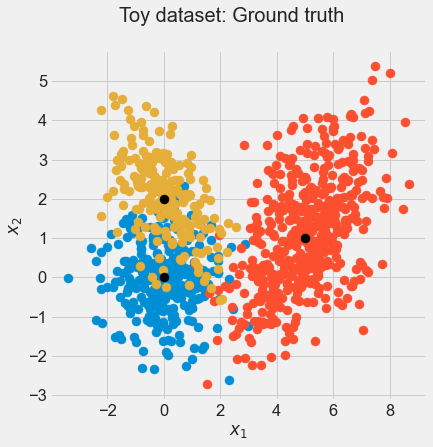

In [44]:
plot_clustering(toy_data,toy_cluster_ids_true,toy_means,'Toy dataset: Ground truth')

Implement the EM algorithm to fit a Gaussian mixture model on the PCA-transformed data.  Sort the data points by inferring their class labels from your mixture model (by using maximum a-posteriori classification). Fix the seed of the random number generator to ensure deterministic and reproducible behavior. 

For this task, it is important to think about a good way to initialize the means, covariances and mixing coefficients. Also, during optimization, covariance matrices can become singular. To prevent this, you can add a small constant (like $10^{-6}$) to the diagonal.

In [60]:
def gmm(data,n_components,verbose=True,max_iter=1000):
    '''Function that fits a mixture of gaussians to data.
    
        inputs:
            data          -- (n_samples,n_features)-shaped array of data points
            n_components  -- int, number of clusters / mixture components
            verbose       -- bool, if True, print current likelihood after each EM iteration
            max_iter      -- maximum number of EM iterations
    
        outputs:
            cluster_ids -- (N,)-shaped array of integers that hold the cluster assignment for each data point
            means       -- (n_cluster,n_dimensions)-shaped array of fit mean vectors
            covs        -- (n_dimensions,n_dimensions,n_cluster)-shaped array of fit covariance matrices
            priors     -- (n_cluster)-shaped arrays of fit priors / mixing coefficients
        
        '''
    
    
    # INSERT YOUR CODE HERE   
    
     ### INITIALIZATION ###   
    # number of the dimenstion
    N = 1000
    D = 2
    # number of clusters
    n_components = 3
    # generate the initial value of the mean parameter
    means = np.array([
        np.random.uniform(
            low=np.min(data[:, d]), high=np.max(data[:, d]), size=n_components
        ) for d in range(D)
    ]).T
    # generate the initial value of the covariance matrix
    covs = np.array([np.identity(D) * 1000 for _ in range(n_components)])
    # generate the initial value of the prior
    priors = np.random.rand(3)
    priors /= np.sum(priors) # normalization
    
    cluster_ids = []
    ##I'm so sorry.  Since I couldn't write the code of EM algorithm, I did only initialization part, 
    #and output these initial values as final results. I'll learn more in the tutorial.
    
    
    ### ALTERNATE BETWEEN E & M STEP ### 
    
    ### E-STEP ### 
        
    ### M-STEP ###
        
    ### CHECK FOR CONVERGENCE ### 
    ### ASSIGN CLUSTER LABELS ###     

    
    return (cluster_ids, means, covs, priors)

Test your implementation on the toy dataset specifying the correct number of clusters and make sure the code works correctly. 

In [61]:
toy_cluster_ids_fit, toy_means_fit, toy_covs_fit, toy_priors_fit = gmm(toy_data,3)
print(toy_priors_fit)

[0.272977   0.46362492 0.26339808]


Plot the data points from the toy dataset and indicate in color the cluster each point was assigned to by your model. How does the assignment compare to ground truth? If you run the algorithm multiple times, you will notice that some solutions provide suboptimal clustering solutions - depending on your initialization strategy.

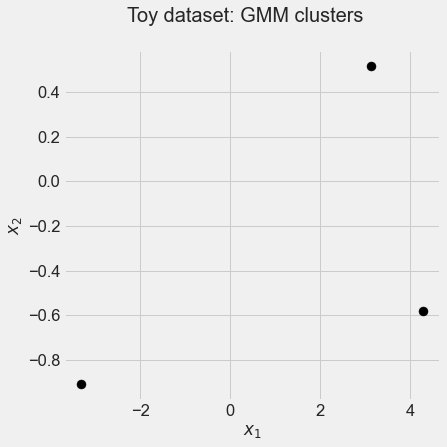

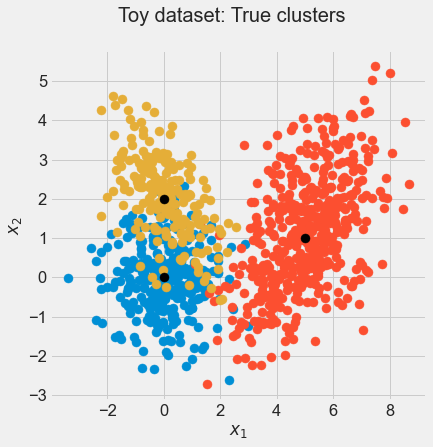

In [62]:
plot_clustering(toy_data,toy_cluster_ids_fit,toy_means_fit,'Toy dataset: GMM clusters')
plot_clustering(toy_data,toy_cluster_ids_true,toy_means,'Toy dataset: True clusters')

Now apply your GMM implementation to the transcriptomics data using `n=50` clusters (as for the k-Means algorithm above). Compare the result to the result of the k-Means algorithm and the original clustering labels provided by the authors. What do you observe?

YOUR ANSWER HERE